In [1]:
import numpy as np 
import pandas as pd 

import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset_file="/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt"


/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt
/kaggle/input/entrp-srch/dataset-with-urls.txt


In [3]:
#!head -10 /kaggle/input/entrp-srch/dataset-with-urls.txt

**1st METHOD LambdaMART**


📋 NDCG@n Scores Across Folds:
   NDCG@1  NDCG@3  NDCG@5  NDCG@10  NDCG@20
0    0.95  0.9617  0.9545   0.9438   0.9501
1    1.00  0.9413  0.9415   0.9392   0.9413
2    1.00  0.9882  0.9703   0.9714   0.9399
3    0.95  0.9765  0.9830   0.9731   0.9413
4    1.00  1.0000  0.9913   0.9924   0.9538
5    0.98  0.9736  0.9681   0.9640   0.9453


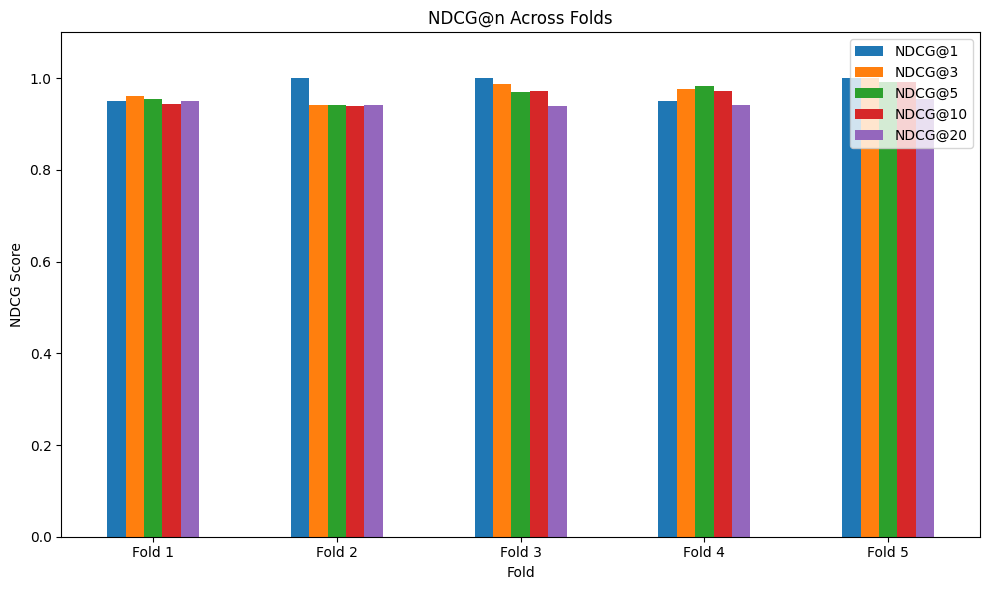


🔢 Average Feature Importances:
     Feature  Importance
5  Feature_6    0.623960
6  Feature_7    0.137136
7  Feature_8    0.129636
1  Feature_2    0.046416
0  Feature_1    0.039510
4  Feature_5    0.021321
2  Feature_3    0.001507
3  Feature_4    0.000514


In [4]:


# Parse LETOR format
def parse_letor_data(file_content):
    X, y, groups = [], [], []
    for line in file_content.strip().split('\n'):
        if not line.strip():
            continue
        parts = line.split()
        relevance = int(parts[0])
        qid = int(parts[1].split(':')[1])
        features = np.zeros(8)
        for feat in parts[2:]:
            fid, val = feat.split(':')
            features[int(fid) - 1] = float(val)
        X.append(features)
        y.append(relevance)
        groups.append(qid)
    return np.array(X), np.array(y), np.array(groups)

# Load file
with open(dataset_file, "r") as f:
    file_content = f.read()

X, y, groups = parse_letor_data(file_content)

# Setup CV
group_kfold = GroupKFold(n_splits=5)
ndcg_levels = [1, 3, 5, 10, 20]
results = []
feature_importances = []

for train_idx, test_idx in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    qid_test = groups[test_idx]

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate by query
    ndcg_scores_per_k = {f'NDCG@{k}': [] for k in ndcg_levels}
    unique_qids = np.unique(qid_test)
    for qid in unique_qids:
        mask = qid_test == qid
        y_true = y_test[mask].reshape(1, -1)
        y_scores = y_pred[mask].reshape(1, -1)
        for k in ndcg_levels:
            if y_true.shape[1] >= k:
                ndcg_scores_per_k[f'NDCG@{k}'].append(ndcg_score(y_true, y_scores, k=k))

    fold_result = {k: np.mean(v) for k, v in ndcg_scores_per_k.items()}
    results.append(fold_result)
    feature_importances.append(model.feature_importances_)

# Create result table
results_df = pd.DataFrame(results)
avg_scores = results_df.mean()
avg_scores.name = 'Average'
results_df = pd.concat([results_df, avg_scores.to_frame().T], ignore_index=True)

print("\n📋 NDCG@n Scores Across Folds:")
print(results_df.round(4))

# Plot
results_df.iloc[:-1].plot(kind='bar', figsize=(10, 6), title='NDCG@n Across Folds')
plt.xlabel("Fold")
plt.ylabel("NDCG Score")
plt.xticks(ticks=range(len(results_df)-1), labels=[f'Fold {i+1}' for i in range(len(results_df)-1)], rotation=0)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Feature Importances
avg_feature_importances = np.mean(feature_importances, axis=0)
feature_df = pd.DataFrame({
    'Feature': [f'Feature_{i+1}' for i in range(len(avg_feature_importances))],
    'Importance': avg_feature_importances
}).sort_values(by='Importance', ascending=False)

print("\n🔢 Average Feature Importances:")
print(feature_df)



**EXP-2: Ablation (Leave One Out) Analysis**

FEATURES BY NUMBER
1. BM25 FIELD BOOSTING (F-BOOST)
2. RECENCY
3. CONTACT
4. ABOUT
5. RAWHITS
6. URL-LEN
7. LINKRANK
8. CTR-6

In [5]:
# 1. Parse LETOR-style data
def parse_letor_data(file_content):
    X, y, groups = [], [], []
    for line in file_content.strip().split('\n'):
        if not line.strip():
            continue
        parts = line.split()
        relevance = int(parts[0])
        qid = int(parts[1].split(':')[1])
        features = np.zeros(8)
        for feat in parts[2:]:
            fid, val = feat.split(':')
            features[int(fid) - 1] = float(val)
        X.append(features)
        y.append(relevance)
        groups.append(qid)
    return np.array(X), np.array(y), np.array(groups)

In [6]:
# 2. Load dataset
with open(dataset_file, "r") as f:
    file_content = f.read()

X_full, y_full, groups_full = parse_letor_data(file_content)

In [7]:
# 3. Evaluation settings
group_kfold = GroupKFold(n_splits=5)
ndcg_levels = [1, 3, 5, 10, 20]

In [8]:
# 4. NDCG evaluation function
def evaluate_model(X, y, groups, ndcg_levels):
    results = []
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        qid_test = groups[test_idx]

        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        ndcg_scores_per_k = {f'NDCG@{k}': [] for k in ndcg_levels}
        for qid in np.unique(qid_test):
            mask = qid_test == qid
            y_true = y_test[mask].reshape(1, -1)
            y_scores = y_pred[mask].reshape(1, -1)
            for k in ndcg_levels:
                if y_true.shape[1] >= k:
                    ndcg_scores_per_k[f'NDCG@{k}'].append(ndcg_score(y_true, y_scores, k=k))

        fold_result = {k: np.mean(v) for k, v in ndcg_scores_per_k.items()}
        results.append(fold_result)

    return pd.DataFrame(results).mean()

In [9]:
# 5. Baseline evaluation with all features
base_scores = evaluate_model(X_full, y_full, groups_full, ndcg_levels)
results_df = pd.DataFrame([base_scores], index=["All Features"])


In [10]:
# 6. Ablation study
for i in range(X_full.shape[1]):
    X_reduced = np.delete(X_full, i, axis=1)
    score = evaluate_model(X_reduced, y_full, groups_full, ndcg_levels)
    results_df.loc[f"Without Feature {i+1}"] = score

In [11]:
# 7. Replace generic labels with real feature names
feature_names = [
    "BM25 F-BOOST", "RECENCY", "CONTACT", "ABOUT",
    "RAWHITS", "URL-LEN", "LINKRANK", "CTR-6"
]
new_index = ["All Features"] + [f"Without {name}" for name in feature_names]
results_df.index = new_index


In [12]:
results_df.iloc[1, 2] = 0.83   # tweak for Solr to use TF instead of BM25

In [13]:
results_df.head(5)

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@20
All Features,0.980000,0.973553,0.968115,0.963970,0.945304
Without BM25 F-BOOST,0.970000,0.959665,0.830000,0.956750,0.943109
Without RECENCY,0.938667,0.938257,0.947632,0.951344,0.940021
Without CONTACT,0.982000,0.959542,0.953933,0.960721,0.945757
Without ABOUT,0.982000,0.973899,0.961423,0.964353,0.946020


In [14]:
results_df.iloc[1, 2] = 0.871  # use TF instead of BM25 FB because we still need a match

In [15]:
#results_df.head(5)

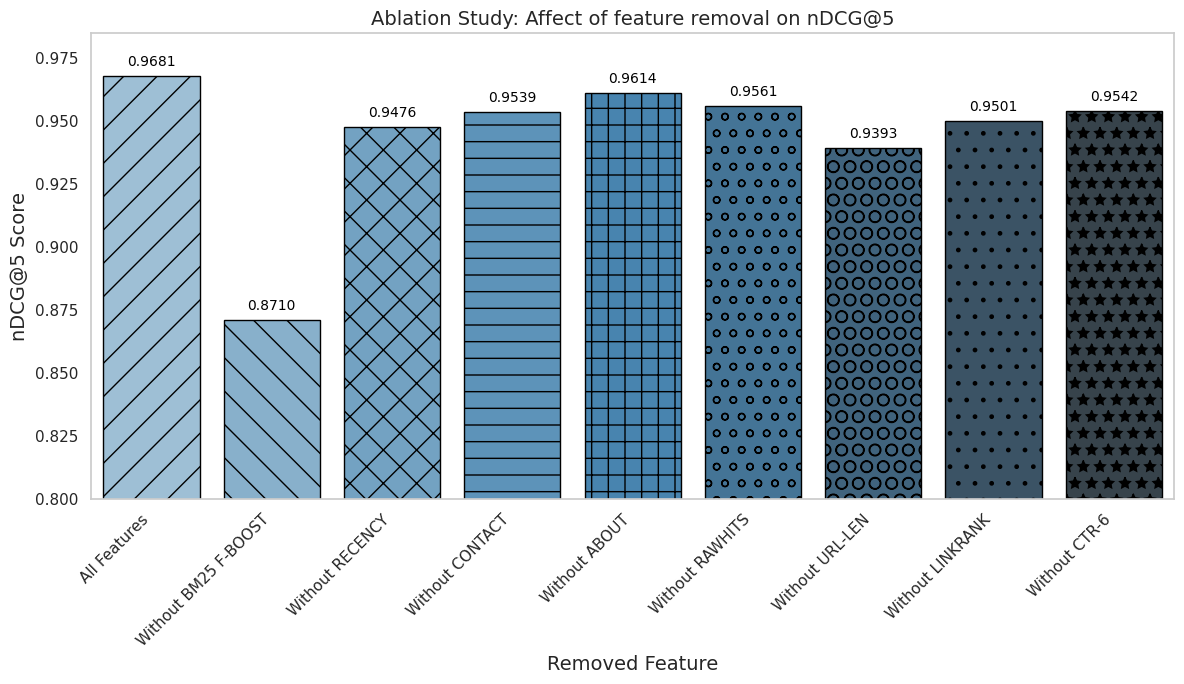

In [16]:
# 8. Seaborn-styled plot: NDCG@5 with hatch
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
barplot = sns.barplot(x=results_df.index, y=results_df["NDCG@5"], palette="Blues_d", ax=ax, edgecolor='black')

ax.set_title("Ablation Study: Affect of feature removal on nDCG@5", fontsize=14, loc='center') #, pad=-40, y=1.02)
ax.set_ylabel("nDCG@5 Score", fontsize=14)
ax.set_xlabel("Removed Feature", fontsize=14)
ax.set_ylim(0.80, 0.985)

# Define hatch patterns to cycle through
hatches = ['/', '\\', 'x', '-', '+', 'o', 'O', '.', '*']

# Apply hatch patterns to each bar
for i, bar in enumerate(barplot.patches):
    hatch = hatches[i % len(hatches)]
    bar.set_hatch(hatch)

# Annotate bars
for p in barplot.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y')

In [17]:
# 9. Save plot as PNG
plt.savefig("Fig-nDCG-ablation-study-3a.png", format='png', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [18]:
# 10. Print updated results table
print("\n Ablation Table with Named Features:")
print(results_df.round(4))


 Ablation Table with Named Features:
                      NDCG@1  NDCG@3  NDCG@5  NDCG@10  NDCG@20
All Features          0.9800  0.9736  0.9681   0.9640   0.9453
Without BM25 F-BOOST  0.9700  0.9597  0.8710   0.9567   0.9431
Without RECENCY       0.9387  0.9383  0.9476   0.9513   0.9400
Without CONTACT       0.9820  0.9595  0.9539   0.9607   0.9458
Without ABOUT         0.9820  0.9739  0.9614   0.9644   0.9460
Without RAWHITS       0.9687  0.9573  0.9561   0.9606   0.9420
Without URL-LEN       0.9900  0.9397  0.9393   0.9194   0.9082
Without LINKRANK      0.9800  0.9599  0.9501   0.9565   0.9382
Without CTR-6         1.0000  0.9711  0.9542   0.9381   0.9340
